<a href="https://colab.research.google.com/github/mlc-ai/notebooks/blob/main/5_Automatic_Program_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ep5: Automatic Program Optimization

## Install packages 

For the purpose of this course, we will use some ongoing development in tvm, which is an open-source machine learning compilation framework. We provide the following command to install a packaged version for mlc course.

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels


## Prelude

In the past chapters, we learned about how to build primitive tensor functions and connect them to form end-to-end model executions. There are three primary types of abstractions we have used so far.

- A computational graph view that drives the high-level executions.
- Abstraction for primitive tensor functions.
- Library function calls via environment function registration.

All of these elements are encapsulated in an IRModule. Most of the MLC processes can be viewed as transformations among tensor functions.

There are many different ways to transform the same program. This chapter will discuss ways to automate some of the processes. 



## Preparations

To begin with, we will import necessary dependencies and create helper functions.



In [2]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

## Recap:  Transform  a Primitive Tensor Function.

Let us begin by reviewing what we did in our previous chapters -- transforming a single primitive tensor function.

In [3]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer[(128, 128), "float32"],
        B: T.Buffer[(128, 128), "float32"],
        C: T.Buffer[(128, 128), "float32"],
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

First, let us define a set of inputs and outputs for evaluation.

In [4]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

We can build and run `MyModule` as follows.





In [5]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 2.121 ms


Next, we transform `MyModule` a bit by reorganizing the loop access pattern.

In [6]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [7]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
sch.mod.show()

Then we can build and run the re-organized program.




In [8]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 0.477 ms


### Transformation Trace

Besides `sch.mod` field, another thing `tir.Schedule` offers is a trace  field that can be used to show the steps involved to get to the transformed module. We can print it out using the following code.

In [9]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True)
sch.reorder(l1, l4, l3, l5)
b6 = sch.decompose_reduction(block=b0, loop=l3)


In [10]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

The above trace aligns with the transformations we specified in `schedule_mm`. One thing to note is that the trace (plus the original program) gives us a way to completely re-derive the final output program. Let us keep that in mind; we will use trace throughout this chapter as another way to inspect the transformations.

## Stochastic Schedule Transformation

Up until now, we have specified every detail about what transformations we want to make on the original TensorIR program. Many of those choices are based on our understanding of the underlying environment, such as cache and hardware unit. 

However, in practice, we may not be able to decide every detail accurately. Instead of doing so, we would like to specify **what are possible ways to transform the program, while leaving out some details**.

One natural way to achieve the goal is to add some stochastic (randomness) elements to our transformations. The following code does that.

In [11]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

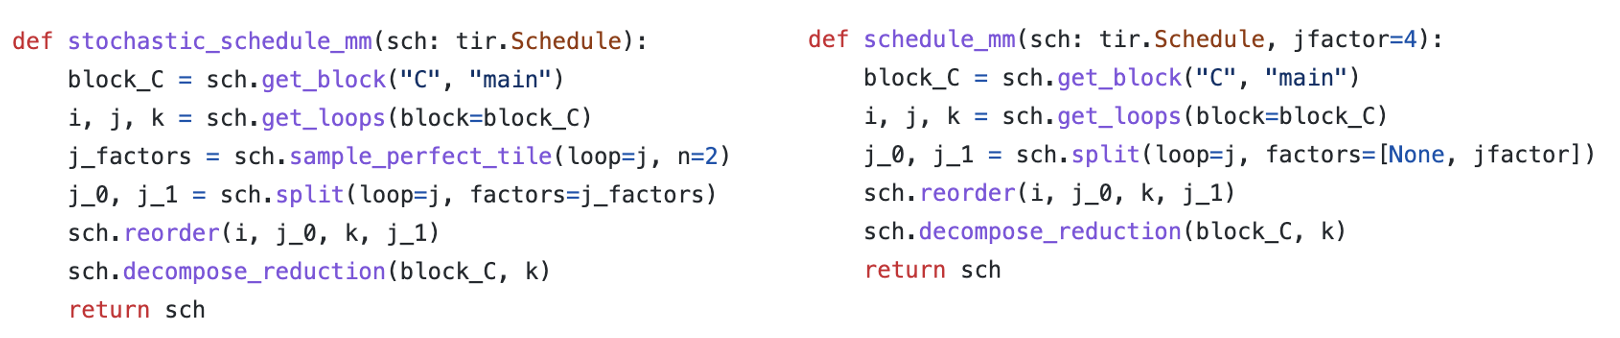


Let us compare `stochastic_schedule_mm` and `schedule_mm` side by side. We can find that the only difference is how to specify `j_factors`. In the case of `schedule_mm`, `j_factors` is passed in as a parameter specified by us. In the case of `stochastic_schedule_mm`, it comes from `sch.sample_perfect_tile`.

As the name suggests, `sch.sample_perfect_tile` tries to draw random numbers to fill in `j_factors`. It samples factors such that they perfectly split the loop. For example, when the original loop size is `128`, possible ways to split the loop include: `[8, 16]`, `[32, 4]`, `[2, 64]` (note `8 * 16 = 32 * 4 = 2 * 64 = 128`). 


Let us first try to see what is the effect of `stochastic_schedule_mm` by running the following code-block. Try to run the following code block multiple times and observe the outcome difference. You might find that the loop bound of `j_1` changes each time we run the code-block.

In [12]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

sch.mod.show()

What is happening here is that each time we run `stochastic_schedule_mm` it draws a  different `j_factors` randomly. We can print out the trace of the latest one to see the decisions we made in sampling.


In [13]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


When we look at the trace, pay close attention to the `decision=[...]` part of `sample_perfect_tile`. They correspond to the value that the `sampling_perfect_tile` picked in our last call to `stochastic_schedule_mm`.

As an alternative way to look at different samples of `stochastic_schedule_mm`, we can run the following block multiple times and look at the trace. 


In [14]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


### Deep Dive into Stochastic Transformation

Now let us take a deeper dive into what happened in stochastic schedule transformations. We can find that it is a simple generalization of the original deterministic transformations, with two additional elements:

- Random variables that come from `sample_perfect_tile` and other sampling operations that we did not cover in the example.
- Schedule operations that take action depending on the random variables.

Let us try to run the stochastic transformation step by step.

In [15]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)

In [16]:
type(j_factors[0])

tvm.tir.expr.Var

Elements in the `j_factors` are not real integer numbers. Instead, they are **symbolic variables** that refer to a random variable being sampled. We can pass these variables to the transformation API to specify choices such as factor values. 

In [17]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])


The schedule trace keeps track of the choices of these symbolic variables in the `decisions` field. So follow-up steps will be able to look up these choices to decide how to split the loop.

In [18]:
sch.mod.show()

If we look at the code at the current time point, we can find that the module remains the same since we only sampled the random variables but have not yet made any transformation actions based on them.

Let us now take some of the actions:

In [19]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

These actions are recorded in the following trace.

In [20]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)


If we retake a look at the code, the transformed module now corresponds to the updated versions after the actions are taken.

In [21]:
sch.mod.show()

We can do some further transformations to get to the final state 

In [22]:
sch.reorder(i, j_0, k, j_1)
sch.decompose_reduction(block_C, k)

tir.BlockRV(0x5654e32a7a20)

In [23]:
sch.mod.show()

## Search Over Stochastic Transformations



One thing that you might realize is that `stochastic_schedule_mm` create a **search space of possible programs** depending on the specific decisions made at each sampling step. 


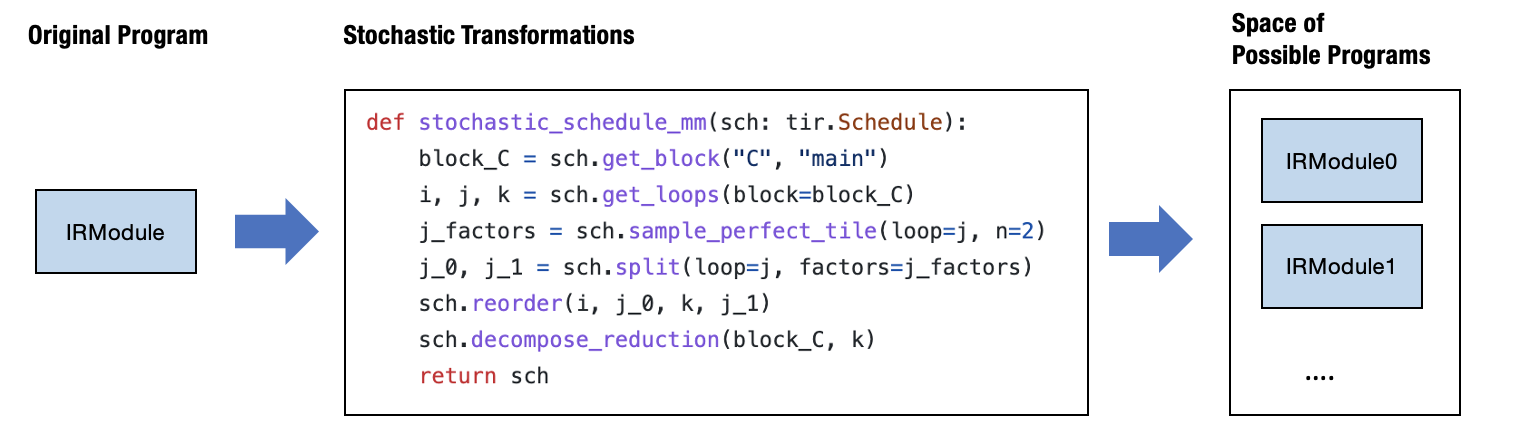


Coming back to our initial intuition, we want to be able to specify a set of **possible programs**  instead of one program. `stochastic_schedule_mm` did exactly that. Of course, one natural question to ask next is what is the best choice.

We will need a search algorithm to do that. To show what can be done here, let us first try the most straightforward search algorithm -- random search, in the following code block. It tries to run `stochastic_schedule_mm` repetitively, gets a transformed module, runs benchmark, then book keep the best one in history.

In [24]:
def random_search(mod: tvm.IRModule, num_trials=5):
    best_result = None
    best_sch = None

    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target="llvm")
        f_timer_after = lib.time_evaluator("main", tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean

        print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
        print(sch.trace)

        # book keep the best result so far
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch      
    
    return best_sch

sch = random_search(MyModule)

=====Attempt 0, time-cost: 0.259 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 0.259 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 0.470 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_it

If we run the code, we can find that it goes over a few choices and then returns the best run throughout five trials.

In [25]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


In practice, we use smarter algorithms. We also need to provide additional utilities, such as benchmarking on remote devices, if we are interested in optimization for other devices. TVM's meta schedule  API provides these additional capabilities.

`meta_schedule` is the namespace that comes to support search over a space of possible transformations. There are many additional things that meta-schedule do behind the scene:
- Parallel benchmarking across many processes.
- Use cost models to avoid benchmarking each time.
- Evolutionary search on the traces instead of randomly sampling at each time.

Despite these magics, the key idea remains the same: **use stochastic transformation to specify a search space of good programs, `tune_tir` API helps to search and find an optimized solution within the search space**.


In [26]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir="./tune_tmp",
    task_name="main"
)

2022-09-19 18:27:26.437 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:27:26.440 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:27:26.441 INFO Working directory: ./tune_tmp
2022-09-19 18:27:26.441 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-09-19 18:27:26.444 INFO LocalBuilder: max_workers = 16
2022-09-19 18:27:26.648 INFO LocalRunner: max_workers = 1
2022-09-19 18:27:26.848 INFO Initializing Task #0: "main"
2022-09-19 18:27:26.878 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials:

/root/miniconda/envs/python310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/root/miniconda/envs/python310/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


2022-09-19 18:27:30.435 INFO [Updated] Task #0: "main"
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |        23.8425 |     175.9169 |              175.9169 |      5 |            
------------------------------------------------------------------------------------------------------------
Total trials: 5
Total latency (us): 175.917

2022-09-19 18:27:30.436 INFO Scheduler picks Task #0: "main"
2022-09-19 18:27:31.706 INFO Sending 0 sample(s) to builder
2022-09-19 18:27:31.707 INFO Sending 0 sample(s) to runner
2022-09-19 18:27:31.708 INFO [Updated] Task #0: "main"
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main 

`tune_tir` functions return an optimized schedule found during the tuning process.

In [27]:
print(sch_tuned.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
sch.enter_postproc()


In [28]:
sch_tuned.mod.show()

In [29]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.176 ms


### Leverage Default AutoScheduling 

In the last section, we showed how to tune a workload with stochastic transformations that we crafted. Metaschedule comes with its own built-in set of generic stochastic transformations that works for a broad set of TensorIR computations. This approach is also called auto-scheduling, as the search space is generated by the system. We can run it by removing the line `space=ms.space_generator.ScheduleFn(stochastic_schedule_mm)`.

Under the hood, the meta-scheduler analyzes each block's data access and loop patterns and proposes stochastic transformations to the program. We won't go into these generic transformations in this chapter but want to note that they are also just stochastic transformations coupled with an analysis of the code. We can use the same mechanisms learned in the last section to enhance auto-scheduling. We will touch base on this topic in future chapters.

In [30]:
sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-09-19 18:27:37.950 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:27:37.952 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:27:37.952 INFO Working directory: ./tune_tmp
2022-09-19 18:27:37.953 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-09-19 18:27:37.964 INFO LocalBuilder: max_workers = 16
2022-09-19 18:27:38.162 INFO LocalRunner: max_workers = 1
2022-09-19 18:27:38.359 INFO Initializing Task #0: "main"
2022-09-19 18:27:38.393 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials:

/root/miniconda/envs/python310/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [31]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.019 ms


The result gets much faster than our original code. We can take a glimpse at the trace and the final code. For the purpose of this chapter, you do not need to understand all the transformations. At a high level, the trace involves:

- More levels of loop tiling transformations.
- Vectorization of intermediate computations.
- Parallelization and unrolling of loops. 


In [32]:
sch_tuned.trace

b0 = sch.get_block(name="C", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4 = sch.get_loops(block=b0)
v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[16, 1, 8, 1])
l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 1, 4, 32])
l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[32, 4])
l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
b25 = sch.cache_write(block=b0, write_buffer_index=0, storage_scope="global")
sch.reverse_compute_at(block=b25, loop=l17, preserve_unit_loops=True)

In [33]:
sch_tuned.mod.show()

### Section Checkpoint

Let us have a checkpoint about what we have learned so far.

- Stochastic schedule allow us to express "what are the possible transformations".
- Metaschedule's `tune_tir` API helps to find a good solution within the space.
- Metaschedule comes with a default built-in set of stochastic transformations that covers a broad range of search space.

## Putting Things Back to End to End Model Execution

Up until now, we have learned to automate program optimization of a single tensor primitive function. How can we put it back and improve our end-to-end model execution?

From the MLC perspective, the automated search is a modular step, and we just need to replace the original primitive function implementation with the new one provided by the tuned result.

We will reuse the two-layer MLP example from the last chapter.


In [34]:
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

Class: Sneaker


/tmp/ipykernel_30733/2167287842.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()



We also download pre-packed model parameters that we will use in our examples.

In [36]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-09-19 18:28:01--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-09-19 18:28:01--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.2’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.04s   

2022-09-19 18:28:01 (9.18 MB/s) - ‘fasionmnist_mlp_pa

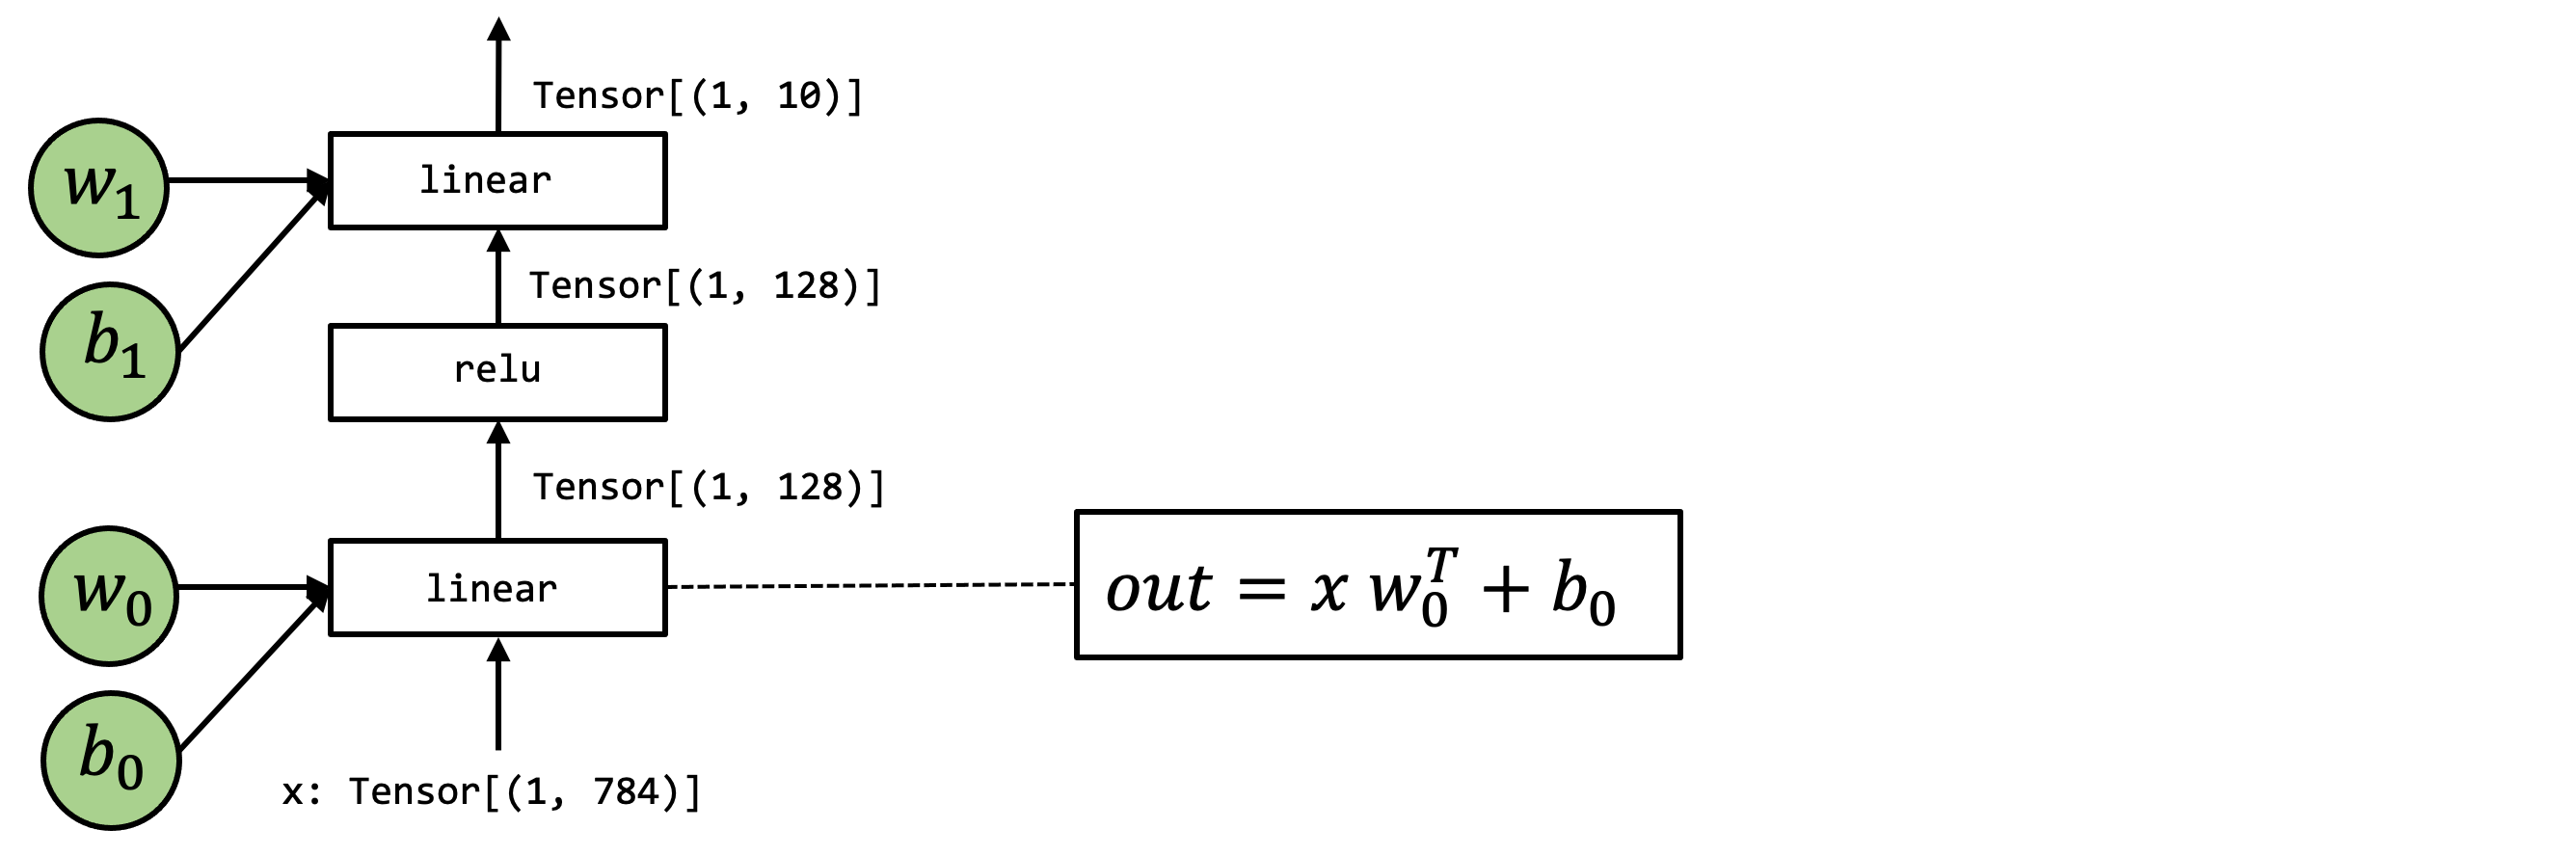

As a reminder, the above figure shows the model of interest.

In [37]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

Let us use a mixture module where most of the components call into environment function and also come with one TensorIR function `linear0`.

In [38]:
@tvm.script.ir_module
class MyModuleMixture: 
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], 
                W: T.Buffer[(128, 784), "float32"], 
                B: T.Buffer[(128,), "float32"], 
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"), 
             w0: Tensor((128, 784), "float32"), 
             b0: Tensor((128,), "float32"), 
             w1: Tensor((10, 128), "float32"), 
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out
        

In [39]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray, 
                 w: tvm.nd.NDArray, 
                 b: tvm.nd.NDArray, 
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray, 
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

We can bind the parameters and see if it gives the correct prediction.

In [40]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [41]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sneaker


The following code evaluates the run time cost of the module before the transformation. Note that because this is a small model, the number can fluctuate a bit between runs, so we just need to read the overall magnitude.

In [42]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.183228 ms


We are now ready to tune the `linear0`. Our overall process is summarized in the following diagram.

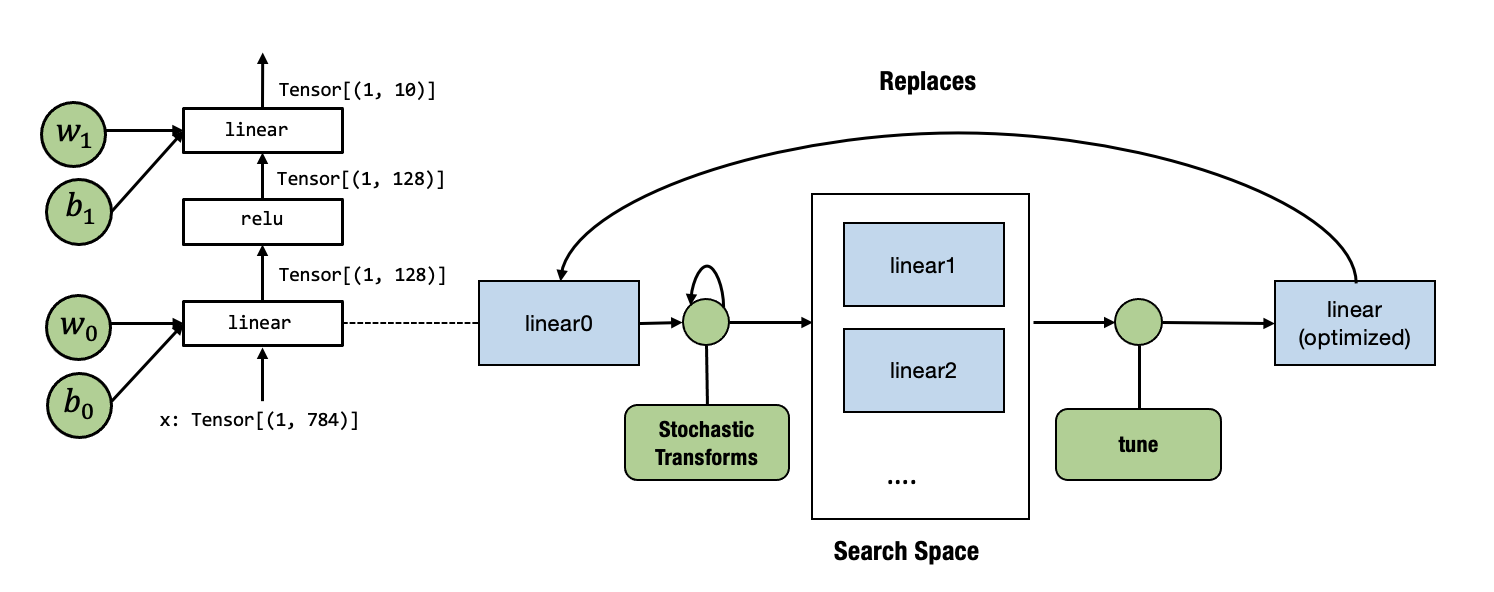

Currently, tune API only takes an IRModule with one `main` function, so we first get the `linear0` out into another module's main function and pass it to tune

In [43]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
mod_linear.show()

In [44]:
sch_tuned_linear = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-09-19 18:28:04.611 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:28:04.613 INFO Logging directory: ./tune_tmp/logs
2022-09-19 18:28:04.613 INFO Working directory: ./tune_tmp
2022-09-19 18:28:04.614 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-09-19 18:28:04.634 INFO LocalBuilder: max_workers = 16
2022-09-19 18:28:04.829 INFO LocalRunner: max_workers = 1
2022-09-19 18:28:05.030 INFO Initializing Task #0: "main"
2022-09-19 18:28:05.078 INFO 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
-----------------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |            
-----------------------------------------------------------------------------------------------------------
Total trials: 0
T

/root/miniconda/envs/python310/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Now we need to replace the original `linear0` with the new function after tuning. We can do that by first getting a `global_var`, a `pointer` reference to the functions inside the IRModule, then calling `update_func` to replace the function with the new one.

In [45]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch_tuned_linear.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)
MyModuleWithParams2.show()

We can find that the `linear0` has been replaced in the above code.

In [46]:
ex = relax.vm.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: Sneaker


Running the code again, we can find that we get an observable amount of time reduction, mainly thanks to the new `linear0` function.

In [47]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.0929456 ms


## Discussions


We might notice that our previous two chapters focused on **abstraction** while this chapter starts to focus on  **transformation**. Stochastic transformations specify what can be possibly optimized without nailing down all the choices. The meta-schedule API helps us to search over the space of possible transformations and pick the best one.

Importantly, putting the search result back into the end-to-end flow is just a matter of replacing the implementation of the original function with a new one that is informed by the tuning process. 

So we again are following the generic MLC process in the figure below. In future lectures, we will introduce more kinds of transformations on primitive functions and computational graph functions. A good MLC process composes these transformations together to form an end deployment form.

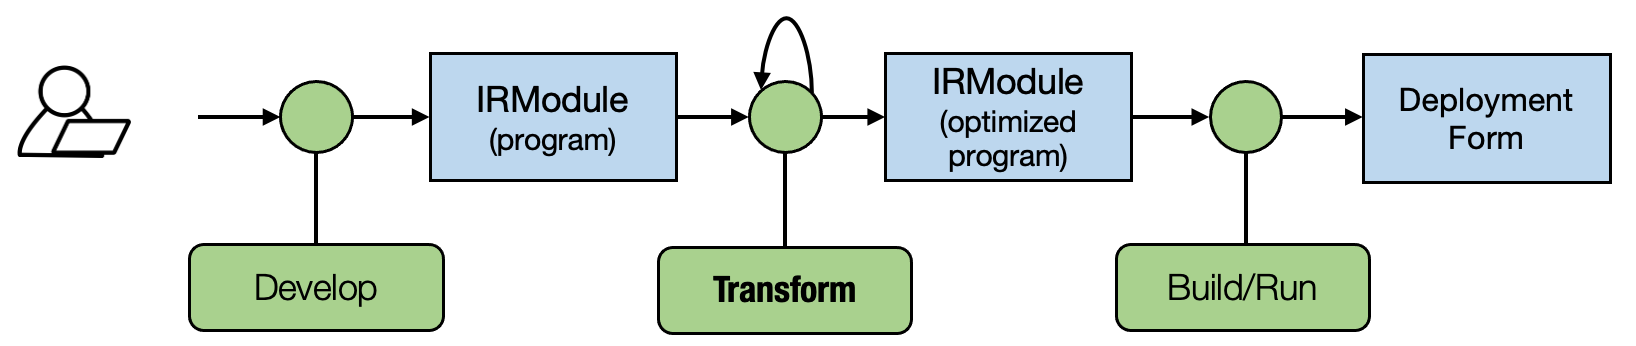

## Summary

- Stochastic transformations help us to specify a search space of possible programs.
- MetaSchedule searches over the search space and finds an optimized one.
- We can use another transformation to replace the primitive tensor function with optimized ones and an updated end-to-end execution flow.